# Mount drive and bucket
Todo: Remove in public version

In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
# Check if the tf version is 2.10.0, this is required to use the 'ignore_class' in the  SparseCategoricalCrossentropy
import tensorflow as tf

if '2.10.0' != tf.__version__:
  !pip uninstall tensorflow -y
  !pip install tensorflow-gpu==2.10.0
  please_restart_the_runtime
else:
  print("TF Version is 2.10.0, ok!")

2023-04-20 11:13:59.120809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 11:13:59.205495: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-20 11:13:59.227976: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-20 11:13:59.719428: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

TF Version is 2.10.0, ok!


In [3]:
from tensorflow import keras
from tensorflow.python.lib.io import file_io

from keras.layers import Input, Dense, Flatten, UnitNormalization, Permute, Conv1D, UpSampling1D, Add, LSTM, Concatenate, Multiply, Activation, Attention, Dropout
from keras.models import Model
from keras.optimizers import Adam

In [4]:
import os
from os import listdir
from os.path import isfile, join

In [5]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import gc
import random
import datetime

---
# Add custom import path for DataStreamCreator, IndicatorCalculator and PredictionCalculator

These libs are not in the standard python directory, so their paths have to be added to the import paths

In [6]:
import sys

In [7]:
# Create the import directories for the DataStreamCreator, the IndicatorCalculator and the PredictionCalculator
dsc_dir = '/content/CryptoCrystalBall/DataStreamCreator'
print(f"dsc_dir: {dsc_dir}")

ind_dir = '/content/CryptoCrystalBall/IndicatorCalculator'
print(f"ind_dir: {ind_dir}")

pc_dir = '/content/CryptoCrystalBall/SignalGenerator/scripts'
print(f"pc_dir: {pc_dir}")

# Add them to the import paths
sys.path.insert(0, dsc_dir)
sys.path.insert(0, ind_dir)
sys.path.insert(0, pc_dir)

dsc_dir: /content/CryptoCrystalBall/DataStreamCreator
ind_dir: /content/CryptoCrystalBall/IndicatorCalculator
pc_dir: /content/CryptoCrystalBall/SignalGenerator/scripts


In [8]:
# Import the actual classes
from IndicatorCalculator import IndicatorCalculator
import DataStreamCreator
from PredictionCalculator import PredictionCalculator

In [9]:
# Define a global random seed
RANDOM_SEED = 42

# Set the seed in np
np.random.seed(RANDOM_SEED)

In [10]:
# X_BLOCK_LENGHT defines how far into the past a 'slice of a chart' shall be
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator#xblockgenerator

# For this ML architecture, the X_BLOCK_LENGHT has to be a member of 2**n, otherwise the feature pyramid cannot be built correctly 

X_BLOCK_LENGHT = 128

In [11]:
# A fixed number of features is used
FEATURES = 149

In [12]:
# Finanical indicator timespans
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/IndicatorCalculator
SHORTSPAN = 7
MIDSPAN = 38
LONGSPAN = 50

In [13]:
COLAB = False

In [14]:
# Set the checkpoint path for saving train progress
if COLAB:
    raise NotImplementedError("Google Buckets have to be implemented in this notebook before using them in Colab!")
    CHECKPOINT_PATH = f"gs://{bucket_name}/chk/"
else:
    CHECKPOINT_PATH = f"/content/bigdata/chk/"

In [15]:
# Check if the notebook is run in google colab, if so, clone the repo
if COLAB:
    print("Running in Colab")

    # Clone the whole repo to get all data and code if not already done
    if not os.path.exists("/content/CryptoCrystalBall"):
      !git clone https://github.com/girsigit/CryptoCrystalBall

    %cd /content

In [16]:
# Try importing the Ta-Lib library, if this fails, try to install it and
# import it again afterwards
try:
    import talib
except:
    !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
    !tar -xzvf ta-lib-0.4.0-src.tar.gz
    %cd ta-lib
    !./configure --prefix=/usr
    !make
    !make install
    !pip install Ta-Lib
    %cd ..

    import talib

In [17]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

---
# Add custom import path for DataStreamCreator and IndicatorCalculator

These libs are not in the standard python directory, so their paths have to be added to the import paths

In [18]:
# Get the current directory
current_dir = os.getcwd()
current_dir_splitted = ["", "content"]
current_dir_splitted

['', 'content']

In [19]:
# Create the import directories for the DataStreamCreator and the IndicatorCalculator
dsc_dir = '/content/CryptoCrystalBall/DataStreamCreator'
print(f"dsc_dir: {dsc_dir}")

ind_dir = '/content/CryptoCrystalBall/IndicatorCalculator'
print(f"ind_dir: {ind_dir}")

# Add them to the import paths
sys.path.insert(0, dsc_dir)
sys.path.insert(0, ind_dir)

dsc_dir: /content/CryptoCrystalBall/DataStreamCreator
ind_dir: /content/CryptoCrystalBall/IndicatorCalculator


In [20]:
# Import the actual classes
from IndicatorCalculator import IndicatorCalculator
import DataStreamCreator

---
# Define all the parameters and variables

In [21]:
# # Define the tick data path
# DATA_PATH = os.path.join(os.sep, *current_dir_splitted, 'DemoData')
# print(f"DATA_PATH: {DATA_PATH}")

In [22]:
# # Define the chart image save path
# IMG_SAVE_PATH = os.path.join(os.sep, *current_dir_splitted, 'Documentation', 'Images')
# print(f"IMG_SAVE_PATH: {IMG_SAVE_PATH}")

In [23]:
# Define a global random seed
RANDOM_SEED = 42

# Set the seed in np
np.random.seed(RANDOM_SEED)

In [24]:
# X_BLOCK_LENGHT defines how far into the past a 'slice of a chart' shall be
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator#xblockgenerator

# For this ML architecture, the X_BLOCK_LENGHT has to be a member of 2**n, otherwise the feature pyramid cannot be built correctly 

# X_BLOCK_LENGHT = 256
X_BLOCK_LENGHT = 128

In [25]:
# How many examples shall be processed at the same time, limited by GPU memory
BATCH_SIZE = 384 # for X_BLOCK_LENGHT = 256
BATCH_SIZE = 512 # for X_BLOCK_LENGHT = 128

In [26]:
# A fixed number of features is used
FEATURES = 116

In [27]:
# Finanical indicator timespans
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/IndicatorCalculator
SHORTSPAN = 7
MIDSPAN = 38
LONGSPAN = 50

In [28]:
# Additional settings for the data stream
# For this notebook, the calculation of pattern indicators is turned off
DATA_STREAM_PARAMETERS = {
    "calcPatternIndicators": False, # No patterns are used
    "calcVolumeInidators": False, # No volume indicators, these are wide spread and may disturb the classifer
    "dropna": True # Drop all tick/indicator table rows containing nan values instead of just replacing them by 0 (which would lead to wrong predictions)
}

# Load the dataset

In [29]:
# Define the dataset path
DATASET_PATH = "/content/dataset/ETF/tickdata/ticks/train"

# Get all file names
TRAIN_FILES = [os.path.join(DATASET_PATH,f) for f in listdir(DATASET_PATH) if isfile(join(DATASET_PATH, f)) and ".csv" in f ]

# Sort them (as a stable basis for randomizing afterwards)
TRAIN_FILES = sorted(TRAIN_FILES)

print(f"The train dataset contains {len(TRAIN_FILES)} files.")
print(TRAIN_FILES[:3])

The train dataset contains 911 files.
['/content/dataset/ETF/tickdata/ticks/train/DE0002635265.csv', '/content/dataset/ETF/tickdata/ticks/train/DE0002635273.csv', '/content/dataset/ETF/tickdata/ticks/train/DE0002635281.csv']


### Not required, dataset is already prepared
---
### Split the dataset into 3 parts
- The **train** set is used to train the machine-learning network then used to predicting future information
- The **test** set is used in the next step. On it a trading (entry/exit) strategy will be developed
- The **eval** set will then be used as an never-seen set to try and evalutate the combination of the ML network and the trading strategy

In [30]:
# # It uses a fixed random seed to allow this cell to be copied to other notebooks producing the same result
# SPLIT_RANDOM_SEED = 666

# TRAIN_SET_SIZE = 0.5
# TEST_SET_SIZE = 0.25
# # EVAL_SET_SIZE: The rest

# # Files are shuffled before splitting
# random.Random(SPLIT_RANDOM_SEED).shuffle(ALL_FILES)

# train_split_index = int(len(ALL_FILES) * TRAIN_SET_SIZE)
# print(f"train_split_index: {train_split_index}")

# test_split_index = int(len(ALL_FILES) * (TRAIN_SET_SIZE + TEST_SET_SIZE))
# print(f"test_split_index: {test_split_index}")

# TRAIN_FILES = ALL_FILES[:train_split_index]
# TEST_FILES = ALL_FILES[train_split_index:test_split_index]
# EVAL_FILES = ALL_FILES[test_split_index:]

# print(f"The train set contains {len(TRAIN_FILES)} files")
# print(f"The test set contains {len(TEST_FILES)} files")
# print(f"The eval set contains {len(EVAL_FILES)} files")

---
# Prepare data source

For training a neural network, first the data source has to be prepared. For this purpose, the method `FileListToDataStream` from the `DataStreamCreator` class is used. This method creates a stream of `X-Block` and `y-data` arrays out of a list of .csv file names, pointing to tick tables (called `EXAMPLE_FILE_PATHS` in this example). For details about `X-Blocks` and `y-data`, please refer to the documentation of the `XBlockGenerator` and the `YDataGenerator` under https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator.

<br>

As y values for training the ML network the possible future gain and it derivation will be used. The y data type `PARAM_DICT_TEMPLATE_Y_DATA_TYPE_PAST_FUTURE_GAIN` will provide both past and future gain, but the model will only be trained on the future gain, as the past gain can be easily calculated directly, also in a live application.

In [31]:
Y_TYPE_DICT = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_PAST_FUTURE_GAIN)

Y_TYPE_DICT["gain_timespan"] = 60
# Y_TYPE_DICT["direction_ma_timespan"] = 14
# Y_TYPE_DICT["derivation_ma_timespan"] = 14

Y_TYPE_DICT

{'dataType': 3,
 'gain_timespan': 60,
 'direction_ma_timespan': 48,
 'derivation_ma_timespan': 48}

In [32]:
XShape = (BATCH_SIZE, X_BLOCK_LENGHT, FEATURES)
XShape

(512, 128, 116)

In [33]:
# A python generator function has to be applied on the dataStream

def pythonGeneratorSignalsTraining():
  # Initialize the FileListToDataStream generator
  dataStreamTraining = DataStreamCreator.FileListToDataStream(fileList = TRAIN_FILES,
                                                      batch_size = BATCH_SIZE,
                                                      X_Block_lenght = X_BLOCK_LENGHT,
                                                      y_type_dict=Y_TYPE_DICT,
                                                      shuffle=True,
                                                      parallel_generators = np.min([BATCH_SIZE, 8]),
                                                      random_seed = RANDOM_SEED,
                                                      **DATA_STREAM_PARAMETERS
                                                      )

  # This while has to integrated into the FileListToDataStream method
  while True:  
    try:
      ne = next(dataStreamTraining)
      _X = ne['X']
      _y = ne['y'][:,[1,3]]
    
      # Limit the y signal to avoid excess
      _y /= 10.0
      _y = np.clip(_y, -10.0, 10.0)

      yield (_X, _y)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [34]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenTraining = tf.data.Dataset.from_generator(pythonGeneratorSignalsTraining, 
                                               output_types = (tf.float32, tf.float32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT, FEATURES),
                                                   (BATCH_SIZE, 2)
                                                   )
                                               )

tfGenTraining = tfGenTraining.prefetch(buffer_size=32)
tfGenTraining

2023-04-20 11:14:02.679137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 11:14:02.705003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 11:14:02.705146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 11:14:02.705793: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

<PrefetchDataset element_spec=(TensorSpec(shape=(512, 128, 116), dtype=tf.float32, name=None), TensorSpec(shape=(512, 2), dtype=tf.float32, name=None))>

---
# Create the neural network

This approach uses a FPN (Feature-Pyramid-Network, https://jonathan-hui.medium.com/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c) architecture, followed by LSTM and Dense regressor heads to extract the future gain information.
The pyramid elements are built in a Res-Net style to provide a good information flow.


Additionally, it is equipped with Attention layers to focus on relevant information. Futhermore, it uses antialiasing to smooth out disturbance.


```
Todo: Create Image of network structure
```

In [35]:
# Create the CreateModelFPNWithAttention model
def CreateModelFPNWithAttention():
  # Define model parameters
  mp = {
      "NAME": "FPNWithAttentionBiggerTimebased",
      "VERSION": "5_FutureOnly_60days_Stable2",
      "CNN_INITIAL_FILTERS": 64,
      "CNN_EXTRACTOR_LAYERS": 6,
      "CNN_INITIAL_KERNEL_SIZE": 2,
      "CNN_MAX_KERNEL_SIZE": 8,
      "FEATURE_PYRAMID_START_INDEX": 2,
      "HEAD_LSTM_SIZE": 64,
      "HEAD_DENSE_SIZE": 32
      }
  
  # Create the model input  
  inputTicksAndIndicators = Input(shape=(X_BLOCK_LENGHT, FEATURES), name='inputTicksAndIndicators', dtype='float32')

  # Apply dropout on the input to make the model robust
  inputTicksAndIndicators = Dropout(0.1, name='inputDropout')(inputTicksAndIndicators)

  # Normalize the input data, as it has a wide value spread (range of 1e8)
  normalized = UnitNormalization(name="UnitNormalizationInput", axis=-2)(inputTicksAndIndicators)

  # ----------------------------------------------------------------------------

  # A 1D-CNN pyramid is used to extract higher-level features out of the time dimension
  conv_layers = []
  aligned_layers = []
  feature_map_layers = []
  anti_aliased_layers = []
  anti_aliased_pyramid_indices = []
  regressor_layers = []

  finalFilters = mp["CNN_INITIAL_FILTERS"] * 2**(mp["FEATURE_PYRAMID_START_INDEX"])
  print(finalFilters) 

  for i in range(mp["CNN_EXTRACTOR_LAYERS"]):
    if 0 == i:
      source_layer = normalized
    else:
      source_layer = feature_conv
    
    filters = int(mp["CNN_INITIAL_FILTERS"]*(2**i))
    kernel_size = mp["CNN_INITIAL_KERNEL_SIZE"]*(2**i)
    kernel_size = int(np.min([mp["CNN_MAX_KERNEL_SIZE"], kernel_size]))
    strides = int(np.min([2,kernel_size]))

    print(f"Step {i}, using {filters} filters with a kernel size of {kernel_size} at strides of {strides}")

    # Create the feature extraction convolution
    res_net_element = Conv1D(filters=source_layer.shape[-1],
                          kernel_size=kernel_size,
                          strides=1, 
                          padding="same",
                          name=f"ResNet_{i}_Conv1D_1")(source_layer)
    
    res_net_element = Activation("relu",
                              name=f"ResNet_{i}_ReLU")(res_net_element)
    
    res_net_element = Conv1D(filters=source_layer.shape[-1],
                          kernel_size=kernel_size,
                          strides=1, 
                          padding="same",
                          name=f"ResNet_{i}_Conv1D_2")(res_net_element)
    
    res_net_element = Add(name=f"ResNet_{i}_Add")([res_net_element, source_layer])
        
    feature_conv = Conv1D(filters=filters,
                          kernel_size=kernel_size,
                          strides=strides, 
                          padding="same",
                          name=f"ResNet_{i}_Feature_Conv1D_FilterDimReduction")(res_net_element)

    attention_map = Attention(name=f"Attention_Layer_{i}")([feature_conv,feature_conv])
    print(f"attention_map.shape: {attention_map.shape}")

    feature_conv_attentioned = Multiply(name=f"Multiply_Apply_Attention_{i}")([feature_conv, attention_map])
    print(f"feature_conv_attentioned.shape: {feature_conv_attentioned.shape}")
    
    conv_layers.append(feature_conv_attentioned)

    # Apply the feature extraction pyramid
    if mp["FEATURE_PYRAMID_START_INDEX"] <= i:
      # Apply a 1x1 convolution to align the channel depth    
      if feature_conv_attentioned.shape[-1] != finalFilters:
        aligned_layer = Conv1D(filters=finalFilters,
                              kernel_size=1,
                              strides=1,
                              padding="same",
                              name=f"Channel_Depth_Alignment_{i}")(feature_conv_attentioned)
      else:
        aligned_layer = feature_conv_attentioned
      
      aligned_layers.append(aligned_layer)

  # Go top-down through the aligned_layers to create the feature_map_layers
  for i in range(mp["CNN_EXTRACTOR_LAYERS"]-1, mp["FEATURE_PYRAMID_START_INDEX"]-1, -1):
    aligned_layers_index = i - mp["FEATURE_PYRAMID_START_INDEX"]
    aligned_layer = aligned_layers[aligned_layers_index]

    print(f"Building feature_map_layers, step {i}. Shape of aligned_layer: {aligned_layer.shape}")

    # The highest-filtered layer is taken as feature map directly
    if i == mp["CNN_EXTRACTOR_LAYERS"]-1:
      feature_map_layers.append(aligned_layer)
      anti_aliased_layers.append(feature_map_layers[-1])
    else:
      # Take the last feature_map_layer and scale it by two
      upsampled = UpSampling1D(size=2,
                               name=f"Pyramid_Upsampling_{i}")(feature_map_layers[-1])

      # Add the aligned_layer
      added = Add(name=f"Pyramid_Add_{i}")([upsampled, aligned_layer])

      # Append as new feature_map_layer
      feature_map_layers.append(added)

      # Apply a convolution with a kernel size of 3 to "reduce the aliasing effect"
      anti_aliased_layer = Conv1D(filters=feature_map_layers[-1].shape[-1],
                                  kernel_size=3,
                                  strides=1,
                                  padding="same",
                                  name=f"Anti_Alias_{i}")(feature_map_layers[-1])

      anti_aliased_layers.append(anti_aliased_layer)

    # Helper storage to keep pyramid index consistent, also in predictor/regressor
    anti_aliased_pyramid_indices.append(i)

  # Apply the predictor head to each feature dimension layer
  for n in range(len(anti_aliased_layers)):
    predictor_input = anti_aliased_layers[n]

    # Get the pyramid index
    pyramid_index = anti_aliased_pyramid_indices[n]

    # Permute the Conv output back
    predictor_input = Permute((2, 1), name=f"PermutePredictorInput_{pyramid_index}")(predictor_input)

    predictor = LSTM(units=mp["HEAD_LSTM_SIZE"],
                     name=f"Predictor_Head_{pyramid_index}_LSTM")(predictor_input)
    
    # Direction and derivation regressor
    regressor = Dense(units=mp["HEAD_DENSE_SIZE"],
                      name=f"Predictor_Head_{pyramid_index}_Dense_Regressor",
                      activation='relu')(predictor)
    
    regressor_layers.append(regressor)
  
  # Add all regressors together
  regressor_conced = Concatenate(name="Concatenate_regressors")(regressor_layers)
  #regressor_conced = Dense(regressor_conced.shape[1], name="Combined_Regressor_1")(regressor_conced)
  #regressor_conced = Dense(regressor_conced.shape[1], name="Combined_Regressor_2")(regressor_conced)

  # The output are two values (direction and derivation) in the range [-1.0, 1.0]
  output = Dense(2, activation="tanh", name="Output")(regressor_conced)
  outputs = [output]

  # Combine it all into a model object
  model = Model(inputs=inputTicksAndIndicators, outputs=outputs, name=mp["NAME"] + "_" + str(mp["VERSION"]))

  return model, mp

model, model_config = CreateModelFPNWithAttention()
print(model_config)
model.summary(line_length=220)

256
Step 0, using 64 filters with a kernel size of 2 at strides of 2
attention_map.shape: (None, 64, 64)
feature_conv_attentioned.shape: (None, 64, 64)
Step 1, using 128 filters with a kernel size of 4 at strides of 2
attention_map.shape: (None, 32, 128)
feature_conv_attentioned.shape: (None, 32, 128)
Step 2, using 256 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 16, 256)
feature_conv_attentioned.shape: (None, 16, 256)
Step 3, using 512 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 8, 512)
feature_conv_attentioned.shape: (None, 8, 512)
Step 4, using 1024 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 4, 1024)
feature_conv_attentioned.shape: (None, 4, 1024)
Step 5, using 2048 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 2, 2048)
feature_conv_attentioned.shape: (None, 2, 2048)
Building feature_map_layers, step 5. Shape of aligned_layer: (None, 2, 256)
Building feature_

# Train the model

In [36]:
# Define the checkpoint name for storing training progress
CHKPNT_NAME = f"{model.name}_GPU_{X_BLOCK_LENGHT}LB"
CHKPNT_NAME

'FPNWithAttentionBiggerTimebased_5_FutureOnly_60days_Stable2_GPU_128LB'

In [37]:
# Set an optimizer
optimizer = Adam(
    learning_rate=1e-03,
    epsilon=1e-06,
    beta_1=0.9,
    beta_2=0.98,
    decay=0.01)

In [38]:
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = ["mse"], 
    metrics=["mae"])

In [39]:
#@title CustomCallback
# This method stores the model weights every `save_freq` batches, or at least at the epoch's end

class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self, save_freq, val_freq, checkpoint_path, model_name, epoch_add=0):
    self.save_freq = save_freq
    self.val_freq = val_freq
    self.checkpoint_path = checkpoint_path
    self.model_name = model_name
    self.current_epoch = 0
    self.epoch_add = epoch_add

  def on_epoch_begin(self, epoch, logs=None):
    self.current_epoch = epoch + self.epoch_add
    # keys = list(logs.keys())
    # print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

  def on_epoch_end(self, epoch, logs=None):
    self.saveTheModel(-1, logs)

  def on_train_batch_end(self, batch, logs=None):
    self.saveTheModel(batch, logs)

  def saveTheModel(self, batch, logs=None):
    if (0 < batch and 0 == batch % self.save_freq) or (0 > batch):
      logging.info(str(datetime.datetime.utcnow()))
    
      if 0 > batch:
        _save_folder = os.path.join(self.checkpoint_path,
                                    self.model_name,
                                    "cp_daily_valid_{:02d}_end".format(self.current_epoch)
                                    )
      else:
        _save_folder = os.path.join(self.checkpoint_path,
                                    self.model_name,
                                    "cp_daily_valid_{:02d}_{:05d}".format(self.current_epoch, batch)
                                    )
      
      fp = os.path.join(_save_folder, "model.h5")
      model.save(fp)
      logging.info(f"Saved model to '{fp}'")
      
      # Save optimizer config
      # c = copy.deepcopy(self.model.optimizer.get_config())

#       fp = os.path.join(_save_folder, "c.pickle")
#       with file_io.FileIO(fp, mode='wb+') as handle:
#         pickle.dump(self.model.optimizer.get_config(), handle, protocol=pickle.HIGHEST_PROTOCOL)
        
#       logging.info(f"Saved optimizer config to '{fp}'")

#       # Save optimizer weights
#       # w = copy.deepcopy(self.model.optimizer.get_weights())

#       fp = os.path.join(_save_folder, "w.pickle")
#       with open(fp, "wb") as handle:
#         # with file_io.FileIO(fp, mode='wb+') as handle:
#         pickle.dump(self.model.optimizer.get_weights(), handle, protocol=pickle.HIGHEST_PROTOCOL)
      
#       logging.info(f"Saved optimizer weights to '{fp}'")
        
      logging.info(f"Did a gc collect: {gc.collect()}")

    # if 0 < batch and 0 == batch % self.val_freq:
    #   print("-------------------------EVAL-------------------------")
    #   model.evaluate(tfgenTest)
    #   print("\n-------------------------EVAL-------------------------")

In [40]:
# If the training is resumed from a previous checkpoint, these epochs can be added to keep model saving consistent
epoch_add = 0

In [41]:
# Define how often the model shall be saved
CALLBACK_EVERY_N_BATCHES = 2000

In [42]:
# Create the custom callback
cc = CustomCallback(checkpoint_path = CHECKPOINT_PATH,
                    model_name = CHKPNT_NAME,
                    save_freq = CALLBACK_EVERY_N_BATCHES,
                    val_freq = CALLBACK_EVERY_N_BATCHES,
                    epoch_add = epoch_add)

In [43]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [44]:
# Todo: Create more elegant solution
log_dir = "gs://ticks_with_indicators_with_volume/logs/TPU/" + CHKPNT_NAME + "_" + datetime.datetime.now().strftime("%Y%m%d%H%M%S")

if not COLAB:
    log_dir = os.path.join("/content/CryptoCrystalBall/Data/logs",log_dir.split("/")[-1])

log_dir

'/content/CryptoCrystalBall/Data/logs/FPNWithAttentionBiggerTimebased_5_FutureOnly_60days_Stable2_GPU_128LB_20230420111404'

In [45]:
# Create a TensorBoard callback for moniting the training progress
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    update_freq=CALLBACK_EVERY_N_BATCHES,
    profile_batch=(5,100)
    )

2023-04-20 11:14:04.062337: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-04-20 11:14:04.062374: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-04-20 11:14:04.062424: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2023-04-20 11:14:04.062799: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2023-04-20 11:14:04.156358: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-04-20 11:14:04.156599: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


In [46]:
# Load previous weights if necessary
#MODEL_PATH = "/content/CryptoCrystalBall/Notebooks/etf_pastfuture_based/FPNWithAttentionBiggerTimebased_2_FutureOnly_60days_GPU_128LB/cp_daily_valid_05_end/model.h5"

#model.load_weights(MODEL_PATH)

In [47]:
# Activate the TensorBoard
%tensorboard --logdir $log_dir --host 0.0.0.0 --port 6006

In [48]:
stop

NameError: name 'stop' is not defined

# Start training

In [ ]:
# Train for one epoch on a higher learning rate to get the model going
model.fit(tfGenTraining,
          epochs=1,
          verbose = 1,
          callbacks=[tensorboard_callback, cc])

In [ ]:
# Decrease the learning rate to avoid overshooting
model.optimizer.learning_rate = 5e-6
logging.info(f"Decreased learning rate: {model.optimizer.learning_rate.numpy()}")

In [ ]:
RANDOM_SEED += 1
RANDOM_SEED

In [ ]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenTraining = tf.data.Dataset.from_generator(pythonGeneratorSignalsTraining, 
                                               output_types = (tf.float32, tf.float32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT, FEATURES),
                                                   (BATCH_SIZE, 2)
                                                   )
                                               )

tfGenTraining = tfGenTraining.prefetch(buffer_size=32)

In [ ]:
# Create a new CustomCallback with 1 epoch added to the logging file name
epoch_add = 1

cc = CustomCallback(checkpoint_path = CHECKPOINT_PATH,
                    model_name = CHKPNT_NAME,
                    save_freq = CALLBACK_EVERY_N_BATCHES,
                    val_freq = CALLBACK_EVERY_N_BATCHES,
                    epoch_add = epoch_add)

In [ ]:
# Train further on with the reduced learning rate
model.fit(tfGenTraining,
          epochs=3,
          verbose = 1,
          callbacks=[tensorboard_callback, cc])

### Different random seed

In [ ]:
RANDOM_SEED += 1
RANDOM_SEED

In [ ]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenTraining = tf.data.Dataset.from_generator(pythonGeneratorSignalsTraining, 
                                               output_types = (tf.float32, tf.float32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT, FEATURES),
                                                   (BATCH_SIZE, 2)
                                                   )
                                               )

tfGenTraining = tfGenTraining.prefetch(buffer_size=32)

In [ ]:
# Create a new CustomCallback with 1 epoch added to the logging file name
epoch_add = 4

cc = CustomCallback(checkpoint_path = CHECKPOINT_PATH,
                    model_name = CHKPNT_NAME,
                    save_freq = CALLBACK_EVERY_N_BATCHES,
                    val_freq = CALLBACK_EVERY_N_BATCHES,
                    epoch_add = epoch_add)

In [ ]:
# Train further on with the reduced learning rate
model.fit(tfGenTraining,
          epochs=3,
          verbose = 1,
          callbacks=[tensorboard_callback, cc])

In [ ]:
stop

# Use the model to predict the future

In [ ]:
Todo important: CustomCallback has to set MODEL_PATH 
--> The folder for the predicted data shall then be named like this

In [49]:
MODEL_PATH = "/content/bigdata/chk/FPNWithAttentionBiggerTimebased_5_FutureOnly_60days_Stable2_GPU_128LB/cp_daily_valid_06_end/model.h5"

In [50]:
model = tf.keras.models.load_model(MODEL_PATH)

In [51]:
TEST_PATH = DATASET_PATH.replace("train", "test")
TEST_PATH

'/content/dataset/ETF/tickdata/ticks/test'

In [52]:
TEST_PATH = '/content/CryptoCrystalBall/Data/Crypto'
TEST_PATH

'/content/CryptoCrystalBall/Data/Crypto'

In [53]:
EVAL_PATH = DATASET_PATH.replace("train", "eval")
EVAL_PATH

'/content/dataset/ETF/tickdata/ticks/eval'

In [54]:
# Get test file names
TEST_FILES = [os.path.join(TEST_PATH,f) for f in listdir(TEST_PATH) if isfile(join(TEST_PATH, f)) and ".csv" in f ]

# Sort them (as a stable basis for randomizing afterwards)
TEST_FILES = sorted(TEST_FILES)

print(f"The test dataset contains {len(TEST_FILES)} files.")
print(TEST_FILES[:3])

The test dataset contains 1 files.
['/content/CryptoCrystalBall/Data/Crypto/ETH-USDT.csv']


In [55]:
# Get test file names
EVAL_FILES = [os.path.join(EVAL_PATH,f) for f in listdir(EVAL_PATH) if isfile(join(EVAL_PATH, f)) and ".csv" in f ]

# Sort them (as a stable basis for randomizing afterwards)
EVAL_FILES = sorted(EVAL_FILES)

print(f"The eval dataset contains {len(EVAL_FILES)} files.")
print(EVAL_FILES[:3])

The eval dataset contains 1063 files.
['/content/dataset/ETF/tickdata/ticks/eval/DE0002635265.csv', '/content/dataset/ETF/tickdata/ticks/eval/DE0002635273.csv', '/content/dataset/ETF/tickdata/ticks/eval/DE0002635281.csv']


In [56]:
BATCH_SIZE = 512

In [57]:
# Create a generator for prediction
# Todo: Use same method as for training to avoid different settings

def pythonGeneratorPrediction(fileList):
  # Initialize the FileListToDataStream generator
  dataStream= DataStreamCreator.FileListToDataStream(fileList = fileList,
                                                     batch_size = BATCH_SIZE,
                                                     X_Block_lenght = X_BLOCK_LENGHT,
                                                     y_type_dict=Y_TYPE_DICT,
                                                     shuffle=False,
                                                     parallel_generators = 1,
                                                     random_seed = RANDOM_SEED,
                                                     **DATA_STREAM_PARAMETERS
                                                    )
  
  # This while has to integrated into the FileListToDataStream method
  while True:  
    try:
      ne = next(dataStream)
      _X = ne['X']
      _y = ne['y']
    
      # Limit the y signal to avoid excess
      _y /= 10.0
      _y = np.clip(_y, -10.0, 10.0)

      yield (_X, _y)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [58]:
# Load a file to visualize the prediction results
FILE_FOR_VISUALIZATION = TEST_FILES[0]
FILE_FOR_VISUALIZATION

'/content/CryptoCrystalBall/Data/Crypto/ETH-USDT.csv'

In [59]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenPrediction = tf.data.Dataset.from_generator(lambda: pythonGeneratorPrediction(fileList=[FILE_FOR_VISUALIZATION]), 
                                               output_types = (tf.float32, tf.float32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT, FEATURES),
                                                   (BATCH_SIZE, 4)
                                                   )
                                               )
tfGenPrediction

<FlatMapDataset element_spec=(TensorSpec(shape=(512, 128, 116), dtype=tf.float32, name=None), TensorSpec(shape=(512, 4), dtype=tf.float32, name=None))>

In [60]:
it = tfGenPrediction.as_numpy_iterator()
while True:
    ne = next(it)

INFO:root:File 'ETH-USDT.csv' loaded, 0 left
ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 57
ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0
ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0
ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0
ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0
ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0
ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0
ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0
ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0
ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0
ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0
ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root

StopIteration: 

In [61]:
# Predict something
p = model.predict(tfGenPrediction)
# p *= 10.0
p.shape

INFO:root:File 'ETH-USDT.csv' loaded, 0 left
2023-04-20 11:15:03.874135: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700
2023-04-20 11:15:04.458922: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


     82/Unknown - 25s 125ms/step

ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 57


     83/Unknown - 25s 125ms/step

ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0


     84/Unknown - 25s 125ms/step

ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0


     85/Unknown - 25s 125ms/step

ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0


     86/Unknown - 26s 125ms/step

ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0


     87/Unknown - 26s 125ms/step

ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0


     88/Unknown - 26s 125ms/step

ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0


     89/Unknown - 26s 125ms/step

ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0


     90/Unknown - 26s 125ms/step

ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0


     91/Unknown - 26s 125ms/step

ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0


     92/Unknown - 26s 125ms/step

ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0


     93/Unknown - 26s 125ms/step

ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0


     94/Unknown - 27s 125ms/step

ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0


     95/Unknown - 27s 125ms/step

ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0


     96/Unknown - 27s 125ms/step

ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0


     97/Unknown - 27s 125ms/step

ERROR:root:X_slice_from_gen.shape[0]: 512
ERROR:root:y_slice_from_gen.shape[0]: 0


     98/Unknown - 27s 125ms/step

98/98 [==============================] - 27s 126ms/step


(50176, 2)

In [62]:
# Store the prediction results in nicely named variables
p_future = p[:,0]
p_future_derivation = p[:,1]

In [ ]:
# # Helper method to get the gain data from the past using the generator
# def getPastDataFromGen(genIn, predictedShapeIn):
#     it = genIn.as_numpy_iterator()

#     y_past_data = np.empty((predictedShapeIn[0], 2))
#     i = 0

#     try:
#         while (ne := next(it)):
#             y_past_data[i:i+ne[1].shape[0],0] = ne[1][:,0]
#             y_past_data[i:i+ne[1].shape[0],1] = ne[1][:,2]

#             i += ne[1].shape[0]

#     except StopIteration:
#         pass

#     return y_past_data
    
# y_past_data = getPastDataFromGen(tfGenPrediction, p.shape)
# y_past_data.shape

In [ ]:
# Todo: Improve plotting of the results

In [ ]:
# plt.plot(y_past_data[:,0])

In [ ]:
# plt.plot(y_past_data[:,1])

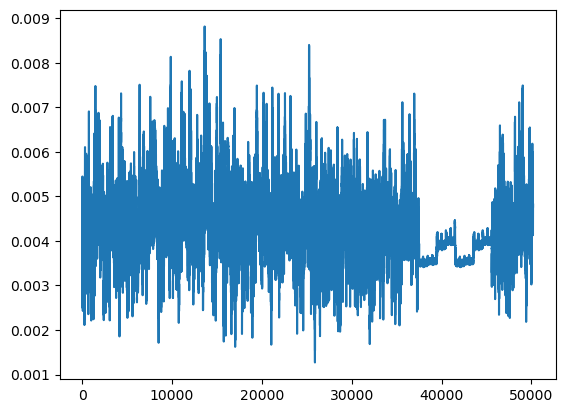

In [63]:
plt.plot(p_future)

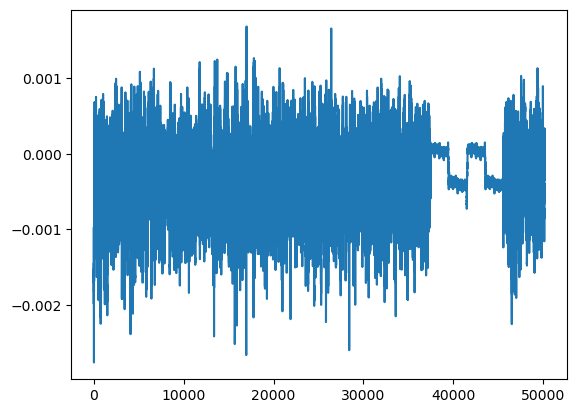

In [64]:
plt.plot(p_future_derivation)

# Add the predictions to the tick table to visualize them

In [65]:
# Load the table
tickDF = pd.read_csv(FILE_FOR_VISUALIZATION)
tickDF

,startsAt,open,high,low,close,volume,quoteVolume
0,1492779600,51.000000,51.000000,51.000000,51.000000,0.000997,0.050873
1,1492783200,51.000000,51.000000,51.000000,51.000000,0.000003,0.000128
2,1492786800,51.000000,51.000000,51.000000,51.000000,0.000000,0.000000
3,1492790400,51.000000,51.000000,51.000000,51.000000,0.000000,0.000000
4,1492794000,51.000000,51.000000,51.000000,51.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
42164,1647244800,2585.520259,2601.475445,2585.401150,2595.000000,16.632924,43103.997904
42165,1647248400,2595.000000,2607.820000,2586.804573,2594.990000,11.321535,29347.127692
42166,1647252000,2596.744850,2596.744850,2585.702991,2593.791600,3.353088,8694.047176
42167,1647255600,2589.081359,2591.849087,2577.827610,2580.003192,2.803050,7245.510782


In [ ]:
# # Because the data is cropped in the batching process (Todo: fix this) and can also not be used fully due to the X-Block and y-data creation,
# # the loaded DF has a bigger shape
# tickDF.shape[0] - p.shape[0]

In [ ]:
# # Crop the DF to meet the prediction
# tickDFcropped = tickDF.iloc[-p.shape[0]:, :]
# tickDFcropped

In [ ]:
# # Plot the prediction again, now over the open price
# chart_name="Predicted direction of price movement with open price"
# fig, ax1 = plt.subplots(figsize=(20,10))
# ax1.set_title(chart_name, fontsize=14)

# _ = ax1.plot(p_future, color="green", label="Predicted p_future")
# _ = ax1.plot(p_future_derivation, color="red", label="Predicted p_future_derivation")
# # _ = ax1.plot(p_neutral, color="gray", label="Predicted neutral")

# ax2 = ax1.twinx()

# ax2.plot(tickDFcropped.loc[:,'open'].values, color="black", label="Price")

# ax1.set_xlabel("Timesteps")
# ax1.set_ylabel("Direction")
# ax2.set_ylabel("Price")

# # Show a legend
# lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# # Save the figure
# # fig_name = "FileListToDataStreamExample_" + chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
# # plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

In [ ]:
#@title Buy and sell signal thresholds
BUY_SIGNAL_THRESHOLD_FUTURE = 0.15 #@param {type:"number"}
BUY_SIGNAL_THRESHOLD_PAST = 0.01 #@param {type:"number"}

SELL_SIGNAL_THRESHOLD_PAST = 0.1 #@param {type:"number"}

In [ ]:
# /content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_06_end/model.h5

# Add predictions to tick tables
# Predict the test and eval set
The future information for these sets is predicted using the trained model, additionally the past gain info is acquired using the `FileListToDataStream` generator. It is then stored together with the tick information as .csv files, which then can be used to develop a trading strategy.

```
Todo: Add link to finder notebooks
```

In [ ]:
stop

In [66]:
BATCH_SIZE = 512

In [67]:
# Create a generator for prediction
# Todo: Use same method as for training to avoid different settings

def pythonGeneratorPrediction(fileList):
    assert 1 == len(fileList) # This gen shall only be used for one file
    
    # Find a batch size which minimizes the non-predicted timestaps (e.g. an optimal divider)
    tickDF = pd.read_csv(fileList[0])
    timesteps = tickDF.shape[0]
    
    # Compensate the timesteps by the X_BLOCK_LENGHT (as the first block ends at index X_BLOCK_LENGHT)
    timesteps -= X_BLOCK_LENGHT
    
    residue_list = []
    min_residue = timesteps + 1

    for batch_size in range(BATCH_SIZE, 31, -1):
        residue = timesteps % batch_size

        # If the residue is bigger than the min one, this batch size can be ignored
        if residue <= min_residue:    
            residue_list.append((batch_size, residue))

        min_residue = np.min([min_residue, residue])

    # Use only batch sizes with the minimum residue
    residue_list = list(filter(lambda x: x[1] == min_residue, residue_list))

    # Sort the residue list by the batch size
    residue_list = sorted(residue_list, key=lambda tup: tup[1])

    logging.info(f"Picked a batch size of {residue_list[0][0]} with a residue of {residue_list[0][1]}.")

    batch_size = residue_list[0][0]
    
    batch_size=256

    # Initialize the FileListToDataStream generator
    dataStream = DataStreamCreator.FileListToDataStream(fileList = fileList,
                                                     batch_size = batch_size,
                                                     X_Block_lenght = X_BLOCK_LENGHT,
                                                     y_type_dict=Y_TYPE_DICT,
                                                     shuffle=False,
                                                     parallel_generators = 1,
                                                     random_seed = RANDOM_SEED,
                                                     **DATA_STREAM_PARAMETERS
                                                    )

    # This while has to integrated into the FileListToDataStream method
    while True:  
        try:
            ne = next(dataStream)
            _X = ne['X']
            _y = ne['y']

            # Limit the y signal to avoid excess
            # _y /= 10.0
            # _y = np.clip(_y, -10.0, 10.0)
            _y = np.zeros(_y.shape)

            yield (_X, _y)
        except StopIteration as si:
            logging.warning("StopIteration in pythonGenerator")
            logging.warning(si)
            return

In [68]:
# PREDICTED_SAVE_PATH = "/content/dataset/etffancy/PastFutureGainV2/test"

In [69]:
# Get the model name and the checkpoint name
model_name, checkpoint_name = tuple(MODEL_PATH.split(os.sep)[-3:-1])
print(f"model_name: '{model_name}'")
print(f"checkpoint_name: '{checkpoint_name}'")

model_name: 'FPNWithAttentionBiggerTimebased_5_FutureOnly_60days_Stable2_GPU_128LB'
checkpoint_name: 'cp_daily_valid_06_end'


In [70]:
# Replace the latest element in the DATASET_PATH with "predicted"
prediction_save_path = DATASET_PATH.split(os.sep)[:-1]
prediction_save_path += ["predicted"]

# Preserve the root symbol
if prediction_save_path[0] == "":
    prediction_save_path[0] = os.sep

# Add the model info to the path
prediction_save_path += [model_name, checkpoint_name]
    
prediction_save_path

['/',
 'content',
 'dataset',
 'ETF',
 'tickdata',
 'ticks',
 'predicted',
 'FPNWithAttentionBiggerTimebased_5_FutureOnly_60days_Stable2_GPU_128LB',
 'cp_daily_valid_06_end']

In [71]:
# Replace the latest element in the DATASET_PATH with "predicted"
prediction_save_path = TEST_FILES[0].split(os.sep)[:-1]
prediction_save_path += ["predicted"]

# Preserve the root symbol
if prediction_save_path[0] == "":
    prediction_save_path[0] = os.sep

# Add the model info to the path
prediction_save_path += [model_name, checkpoint_name]
    
prediction_save_path

['/',
 'content',
 'CryptoCrystalBall',
 'Data',
 'Crypto',
 'predicted',
 'FPNWithAttentionBiggerTimebased_5_FutureOnly_60days_Stable2_GPU_128LB',
 'cp_daily_valid_06_end']

In [72]:
# Check each path element and create it if necessary
for i in range(1, len(prediction_save_path)):
    partial_path_string = os.path.join(*prediction_save_path[:i+1])

    if not os.path.exists(partial_path_string):
        os.mkdir(partial_path_string)
        
# Create the test and eval save folders
PREDICTION_SAVE_PATH_TEST = os.path.join(*(prediction_save_path + ["test"]))
if not os.path.exists(PREDICTION_SAVE_PATH_TEST):
    os.mkdir(PREDICTION_SAVE_PATH_TEST)

PREDICTION_SAVE_PATH_EVAL = os.path.join(*(prediction_save_path + ["eval"]))
if not os.path.exists(PREDICTION_SAVE_PATH_EVAL):
    os.mkdir(PREDICTION_SAVE_PATH_EVAL)

print(f"PREDICTION_SAVE_PATH_TEST: '{PREDICTION_SAVE_PATH_TEST}'")
print(f"PREDICTION_SAVE_PATH_EVAL: '{PREDICTION_SAVE_PATH_EVAL}'")

PREDICTION_SAVE_PATH_TEST: '/content/CryptoCrystalBall/Data/Crypto/predicted/FPNWithAttentionBiggerTimebased_5_FutureOnly_60days_Stable2_GPU_128LB/cp_daily_valid_06_end/test'
PREDICTION_SAVE_PATH_EVAL: '/content/CryptoCrystalBall/Data/Crypto/predicted/FPNWithAttentionBiggerTimebased_5_FutureOnly_60days_Stable2_GPU_128LB/cp_daily_valid_06_end/eval'


In [74]:
fileList=[FILE_FOR_VISUALIZATION]

In [75]:
df = pd.read_csv(fileList[0])
df.set_index("startsAt", inplace = True)
df.sort_index(inplace = True)
df

,open,high,low,close,volume,quoteVolume
startsAt,,,,,,
1492779600,51.000000,51.000000,51.000000,51.000000,0.000997,0.050873
1492783200,51.000000,51.000000,51.000000,51.000000,0.000003,0.000128
1492786800,51.000000,51.000000,51.000000,51.000000,0.000000,0.000000
1492790400,51.000000,51.000000,51.000000,51.000000,0.000000,0.000000
1492794000,51.000000,51.000000,51.000000,51.000000,0.000000,0.000000
...,...,...,...,...,...,...
1647244800,2585.520259,2601.475445,2585.401150,2595.000000,16.632924,43103.997904
1647248400,2595.000000,2607.820000,2586.804573,2594.990000,11.321535,29347.127692
1647252000,2596.744850,2596.744850,2585.702991,2593.791600,3.353088,8694.047176


In [76]:
BATCH_SIZE

512

In [ ]:
fileList = TEST_FILES
PREDICTED_SAVE_PATH = PREDICTION_SAVE_PATH_TEST

pd.options.mode.chained_assignment = None  # default='warn'

for file_index in tqdm(range(0, len(fileList))):
    try:
        filename = fileList[file_index]

        logging.info(f"\nFile name: '{filename}' for index {file_index}")
        
        p = model.predict(pythonGeneratorPrediction(fileList=[filename]), verbose = 1)

        p_future_gain = p[:,0]
        p_future_gain_derivation = p[:,1]

        # Load the tick table
        tickDF = pd.read_csv(filename)
        tickDF.set_index("startsAt", inplace=True)
        
        logging.info(f"tickDF.shape: {tickDF.shape}, p.shape: {p.shape}, len difference: {tickDF.shape[0] - p.shape[0]}")
        
        # Important: If you want to create one X-Block, e.g. for predicting on live data, you have to feed a `tick_and_indicator_DF` with one more row,
        # as the latest row is ignored. This is due to the circumstance that in a live environment the latest tick would change during the day, and therefore
        # cannot be used. --> If you want a 128-timesteps X-Block, you have to feed 129 `tick_and_indicator_DF`-rows.

        # For a X_BLOCK_LEN of 128, tickDF.iloc[:129] will be the first row that has a prediced value

        startIndex = tickDF.index[X_BLOCK_LENGHT]
        endIndex = tickDF.index[X_BLOCK_LENGHT+p.shape[0]-1]
        
        tickDF.loc[startIndex:endIndex, "p_future_gain"] = p[:,0]
        tickDF.loc[startIndex:endIndex, "p_future_gain_derivation"] = p[:,1]       
        
        # Save the DF
        tickDF.to_csv(os.path.join(PREDICTED_SAVE_PATH, filename.split(os.path.sep)[-1]))

        logging.info("Saved the predicted data.\n")
        
    except KeyboardInterrupt:
        raise
    except Exception as ex:
        logging.warning(str(ex))

  0%|                                                     | 0/1 [00:00<?, ?it/s]INFO:root:
File name: '/content/CryptoCrystalBall/Data/Crypto/ETH-USDT.csv' for index 0
INFO:root:Picked a batch size of 40 with a residue of 1.


In [ ]:
stop

In [ ]:
fileList = EVAL_FILES
PREDICTED_SAVE_PATH = PREDICTION_SAVE_PATH_EVAL

pd.options.mode.chained_assignment = None  # default='warn'

for file_index in tqdm(range(0, len(fileList))):
    try:
        filename = fileList[file_index]

        logging.info(f"\nFile name: '{filename}' for index {file_index}")
        
        p = model.predict(pythonGeneratorPrediction(fileList=[filename]), verbose = 0)        

        p_future_gain = p[:,0]
        p_future_gain_derivation = p[:,1]        

        # Load the tick table
        tickDF = pd.read_csv(filename)
        tickDF.set_index("startsAt", inplace=True)
        
        logging.info(f"tickDF.shape: {tickDF.shape}, p.shape: {p.shape}, len difference: {tickDF.shape[0] - p.shape[0]}")
        
        # Important: If you want to create one X-Block, e.g. for predicting on live data, you have to feed a `tick_and_indicator_DF` with one more row,
        # as the latest row is ignored. This is due to the circumstance that in a live environment the latest tick would change during the day, and therefore
        # cannot be used. --> If you want a 128-timesteps X-Block, you have to feed 129 `tick_and_indicator_DF`-rows.

        # For a X_BLOCK_LEN of 128, tickDF.iloc[:129] will be the first row that has a prediced value

        startIndex = tickDF.index[X_BLOCK_LENGHT]
        endIndex = tickDF.index[X_BLOCK_LENGHT+p.shape[0]-1]
        
        tickDF.loc[startIndex:endIndex, "p_future_gain"] = p[:,0]
        tickDF.loc[startIndex:endIndex, "p_future_gain_derivation"] = p[:,1]       
        
        # Save the DF
        tickDF.to_csv(os.path.join(PREDICTED_SAVE_PATH, filename.split(os.path.sep)[-1]))

        logging.info("Saved the predicted data.\n")
        
    except KeyboardInterrupt:
        raise
    except Exception as ex:
        logging.warning(str(ex))